In [1]:
import numpy as np
import xarray as xr
import intake
import xesmf as xe
import glob
import pandas as pd

import warnings

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import from_levels_and_colors
from matplotlib.colors import TwoSlopeNorm, Normalize
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import copy

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# read in the saved json file and load the models
json_file = '/mnt/lustre01/pf/b/b381265/rfmip_analysis/rfmip_models.json'
collection = intake.open_esm_datastore(json_file)
collection.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path,opendap_url
0,RFMIP,EC-Earth-Consortium,EC-Earth3,piClim-aer,r1i1p1f1,Amon,clt,gr,NaN,v20200324,185001-185012,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
1,RFMIP,EC-Earth-Consortium,EC-Earth3,piClim-aer,r1i1p1f1,Amon,clt,gr,NaN,v20200324,185101-185112,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
2,RFMIP,EC-Earth-Consortium,EC-Earth3,piClim-aer,r1i1p1f1,Amon,clt,gr,NaN,v20200324,185201-185212,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
3,RFMIP,EC-Earth-Consortium,EC-Earth3,piClim-aer,r1i1p1f1,Amon,clt,gr,NaN,v20200324,185301-185312,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
4,RFMIP,EC-Earth-Consortium,EC-Earth3,piClim-aer,r1i1p1f1,Amon,clt,gr,NaN,v20200324,185401-185412,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...


In [3]:
# check number of realizations per model
collection.df.groupby("source_id")["member_id"].nunique()

source_id
EC-Earth3        1
IPSL-CM6A-LR     5
MPI-ESM1-2-LR    3
NorESM2-LM       1
Name: member_id, dtype: int64

#### Maps of RFMIP-SpAer ERF$_{all}$, fERF$_{cld}$, and (1-f)ERF$_{clr}$ (columns)  for each model (rows) and model range (3 columns x 5 rows) 

In [4]:
subset = collection.search(source_id = ['IPSL-CM6A-LR','MPI-ESM1-2-LR','NorESM2-LM'],
                           experiment_id=['piClim-control','piClim-spAer-aer'],
                           variable_id=['clt', 'rsdt', 'rlut', 'rsut', 'rsutcs', 'rlutcs']
                          ) 
subset.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,time_range,path,opendap_url
0,RFMIP,IPSL,IPSL-CM6A-LR,piClim-control,r1i1p1f1,Amon,clt,gr,NaN,v20181204,201401-204312,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
1,RFMIP,IPSL,IPSL-CM6A-LR,piClim-control,r1i1p1f1,Amon,rlut,gr,NaN,v20181204,201401-204312,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
2,RFMIP,IPSL,IPSL-CM6A-LR,piClim-control,r1i1p1f1,Amon,rlutcs,gr,NaN,v20181204,201401-204312,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
3,RFMIP,IPSL,IPSL-CM6A-LR,piClim-control,r1i1p1f1,Amon,rsdt,gr,NaN,v20181204,201401-204312,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...
4,RFMIP,IPSL,IPSL-CM6A-LR,piClim-control,r1i1p1f1,Amon,rsut,gr,NaN,v20181204,201401-204312,/mnt/lustre02/work/ik1017/CMIP6/data/CMIP6/RFM...,http://esgf3.dkrz.de/thredds/dodsC/cmip6/RFMIP...


In [5]:
subset.df.groupby("source_id")["member_id"].nunique()

source_id
IPSL-CM6A-LR     5
MPI-ESM1-2-LR    3
NorESM2-LM       1
Name: member_id, dtype: int64

In [6]:
subset.df.groupby("source_id")["member_id"].unique()

source_id
IPSL-CM6A-LR     [r1i1p1f1, r2i1p1f1, r3i1p1f1, r4i1p1f1, r5i1p...
MPI-ESM1-2-LR                       [r1i1p1f1, r2i1p1f1, r3i1p1f1]
NorESM2-LM                                              [r1i1p1f1]
Name: member_id, dtype: object

In [7]:
kwargs = {
    'zarr_kwargs':{
        'consolidated':True,
        'use_cftime':True,
        'decode_times':True
    }
}
dset_dict = subset.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [8]:
[key for key in dset_dict.keys()]

['RFMIP.IPSL.IPSL-CM6A-LR.piClim-spAer-aer.Amon.gr',
 'RFMIP.IPSL.IPSL-CM6A-LR.piClim-control.Amon.gr',
 'RFMIP.MPI-M.MPI-ESM1-2-LR.piClim-spAer-aer.Amon.gn',
 'RFMIP.NCC.NorESM2-LM.piClim-control.Amon.gn',
 'RFMIP.MPI-M.MPI-ESM1-2-LR.piClim-control.Amon.gn',
 'RFMIP.NCC.NorESM2-LM.piClim-spAer-aer.Amon.gn']

In [9]:
# first subset: EC-EARTH and piClim-aer (same as the simple plume aerosol)

sub_aer = collection.search(source_id='EC-Earth3',variable_id=['clt', 'rsdt', 'rlut', 'rsut', 'rsutcs', 'rlutcs'])

sub_aer.df.groupby("source_id")["experiment_id"].unique()

source_id
EC-Earth3    [piClim-aer, piClim-anthro, piClim-control]
Name: experiment_id, dtype: object

In [10]:
dset_dict_aer = sub_aer.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [11]:
list(dset_dict_aer.keys())

['RFMIP.EC-Earth-Consortium.EC-Earth3.piClim-anthro.Amon.gr',
 'RFMIP.EC-Earth-Consortium.EC-Earth3.piClim-control.Amon.gr',
 'RFMIP.EC-Earth-Consortium.EC-Earth3.piClim-aer.Amon.gr']

In [12]:
# averaging over dim=member_id
ipsl_control = dset_dict['RFMIP.IPSL.IPSL-CM6A-LR.piClim-control.Amon.gr'].load().mean(dim='member_id', keep_attrs=True)
ipsl_spaer = dset_dict['RFMIP.IPSL.IPSL-CM6A-LR.piClim-spAer-aer.Amon.gr'].load().mean(dim='member_id', keep_attrs=True)
noresm_control = dset_dict['RFMIP.NCC.NorESM2-LM.piClim-control.Amon.gn'].load().mean(dim='member_id', keep_attrs=True)
noresm_spaer = dset_dict['RFMIP.NCC.NorESM2-LM.piClim-spAer-aer.Amon.gn'].load().mean(dim='member_id', keep_attrs=True)
mpiesm_control = dset_dict['RFMIP.MPI-M.MPI-ESM1-2-LR.piClim-control.Amon.gn'].load().mean(dim='member_id', keep_attrs=True)
mpiesm_spaer = dset_dict['RFMIP.MPI-M.MPI-ESM1-2-LR.piClim-spAer-aer.Amon.gn'].load().mean(dim='member_id', keep_attrs=True)
ecearth_control_var = dset_dict_aer['RFMIP.EC-Earth-Consortium.EC-Earth3.piClim-control.Amon.gr'].load().mean(dim='member_id', keep_attrs=True)
ecearth_spaer_var = dset_dict_aer['RFMIP.EC-Earth-Consortium.EC-Earth3.piClim-aer.Amon.gr'].load().mean(dim='member_id', keep_attrs=True)

In [13]:
ipsl_spaer

<xarray.Dataset>
Dimensions:      (lat: 143, lon: 144, time: 360, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) object 2014-01-16 12:00:00 ... 2043-12-16 12:00:00
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) object 2014-01-01 00:00:00 ... 2044-01-...
    clt          (time, lat, lon) float32 59.02 59.02 59.02 ... 98.47 98.47
    rlut         (time, lat, lon) float32 188.0 188.0 188.0 ... 167.4 167.4
    rlutcs       (time, lat, lon) float32 188.7 188.7 188.7 ... 167.7 167.7
    rsdt         (time, lat, lon) float32 498.2 498.2 498.2 ... 0.0 0.0 0.0
    rsut         (time, lat, lon) float32 351.7 351.7 351.7 ... 0.0 0.0 0.0
    rsutcs       (time, lat, lon) float32 349.8 349.8 349.8 ... 0.0 0.0 0.0
Attributes: (12/48)
    product:                 model-output
    parent_time_units:       days since 1850-01-01 00:00:00
    parent_experiment_id:    piControl
    source:                  IPSL-CM6A-LR (2017):  atmos: LMDZ (NPv6, N96; 14...
    external_variables:      areacella
    initialization_index:    1
    ...                      ...
    Conventions:             CF-1.7 CMIP-6.2
    variant_info:            Starting from different restart file of the pre-...
    title:                   IPSL-CM6A-LR model output prepared for CMIP6 / R...
    forcing_index:           1
    table_id:                Amon
    intake_esm_dataset_key:  RFMIP.IPSL.IPSL-CM6A-LR.piClim-spAer-aer.Amon.gr

In [14]:
# including the second realization of EC-Earth3
path_ec_control = glob.glob("/work/bb1198/b381265/data/CMIP6/RFMIP/EC-Earth3/rfmip-selection/rfmip-spaer-rfco/rfco/CMIP6/RFMIP/EC-Earth-Consortium/EC-Earth3/piClim-control/r2i1p1f1/Amon/*/*/*/*.nc")
path_ec_aerosol = glob.glob("/work/bb1198/b381265/data/CMIP6/RFMIP/EC-Earth3/rfmip-selection/rfmip-spaer-rfae/rfae/CMIP6/RFMIP/EC-Earth-Consortium/EC-Earth3/piClim-aer/r2i1p1f1/Amon/*/*/*/*.nc")

ds_control = xr.open_mfdataset(path_ec_control)
ds_aerosol = xr.open_mfdataset(path_ec_aerosol)

In [15]:
ds_control = ds_control.drop_vars(['rldscs','rlds','rldscs','rlus','rsds','rsus'])
ds_aerosol = ds_aerosol.drop_vars(['rldscs','rlds','rldscs','rlus','rsds','rsus'])
ds_control

<xarray.Dataset>
Dimensions:    (time: 1080, bnds: 2, lat: 256, lon: 512)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 1939-12-16T12:00:00
  * lat        (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon        (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(12, 256, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(12, 512, 2), meta=np.ndarray>
    clt        (time, lat, lon) float32 dask.array<chunksize=(12, 256, 512), meta=np.ndarray>
    rlut       (time, lat, lon) float32 dask.array<chunksize=(12, 256, 512), meta=np.ndarray>
    rlutcs     (time, lat, lon) float32 dask.array<chunksize=(12, 256, 512), meta=np.ndarray>
    rsdt       (time, lat, lon) float32 dask.array<chunksize=(12, 256, 512), meta=np.ndarray>
    rsut       (time, lat, lon) float32 dask.array<chunksize=(12, 256, 512), meta=np.ndarray>
    rsutcs     (time, lat, lon) float32 dask.array<chunksize=(12, 256, 512), meta=np.ndarray>
Attributes: (12/49)
    Conventions:                        CF-1.7 CMIP-6.2
    activity_id:                        RFMIP AerChemMIP
    branch_method:                      standard
    branch_time_in_child:               0.0
    branch_time_in_parent:              0.0
    comment:                            Production: Thomas Reerink at KNMI
    ...                                 ...
    title:                              EC-Earth3 output prepared for CMIP6
    tracking_id:                        hdl:21.14100/237fc25c-89eb-4706-9107-...
    variable_id:                        clt
    variant_label:                      r2i1p1f1
    license:                            CMIP6 model data produced by EC-Earth...
    cmor_version:                       3.5.0

In [16]:
ecearth_aerosol_members = xr.concat([ecearth_spaer_var, ds_aerosol.sel(time=ds_control.time[:360]).load()], dim='member_id')
ecearth_spaer = ecearth_aerosol_members.mean(dim='member_id', keep_attrs=True)
ecearth_spaer

<xarray.Dataset>
Dimensions:   (lon: 1024, time: 360, lat: 256, bnds: 2)
Coordinates:
  * lon       (lon) float64 0.0 0.3516 0.7031 1.055 ... 358.6 358.9 359.3 359.6
  * time      (time) datetime64[ns] 1850-01-16T12:00:00 ... 1879-12-16T12:00:00
  * lat       (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds, time) float64 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
    lon_bnds  (lon, bnds, time) float64 -0.3516 -0.3516 -0.3516 ... 360.0 360.0
    clt       (time, lat, lon) float32 56.15 74.78 56.15 ... 91.83 90.25 91.83
    rlut      (time, lat, lon) float32 185.6 185.9 185.6 ... 161.2 165.6 161.2
    rlutcs    (time, lat, lon) float32 193.0 196.0 193.0 ... 174.4 179.6 174.5
    rsdt      (time, lat, lon) float32 495.7 495.7 495.7 495.7 ... 0.0 0.0 0.0
    rsut      (time, lat, lon) float32 356.9 356.9 356.9 356.9 ... 0.0 0.0 0.0
    rsutcs    (time, lat, lon) float32 348.8 347.4 348.8 347.4 ... 0.0 0.0 0.0
Attributes: (12/46)
    product:                 model-output
    table_info:              Creation Date:(09 May 2019) MD5:1274579b91c9885c...
    parent_time_units:       days since 1850-01-01
    parent_experiment_id:    piControl
    source:                  EC-Earth3 (2019): \naerosol: none\natmos: IFS cy...
    external_variables:      areacella
    ...                      ...
    Conventions:             CF-1.7 CMIP-6.2
    title:                   EC-Earth3 output prepared for CMIP6
    forcing_index:           1
    variant_label:           r1i1p1f1
    table_id:                Amon
    intake_esm_dataset_key:  RFMIP.EC-Earth-Consortium.EC-Earth3.piClim-aer.A...

In [17]:
ecearth_control_members = xr.concat([ecearth_control_var, ds_control.sel(time=ds_control.time[:360]).load()], dim='member_id')
ecearth_control = ecearth_control_members.mean(dim='member_id', keep_attrs=True)
ecearth_control

<xarray.Dataset>
Dimensions:   (lon: 1024, time: 360, lat: 256, bnds: 2)
Coordinates:
  * lon       (lon) float64 0.0 0.3516 0.7031 1.055 ... 358.6 358.9 359.3 359.6
  * time      (time) datetime64[ns] 1850-01-16T12:00:00 ... 1879-12-16T12:00:00
  * lat       (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds, time) float64 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
    lon_bnds  (lon, bnds, time) float64 -0.3516 -0.3516 -0.3516 ... 360.0 360.0
    clt       (time, lat, lon) float32 58.42 60.67 58.42 ... 90.79 72.97 90.84
    rlut      (time, lat, lon) float32 186.7 186.7 186.7 ... 165.9 170.2 165.9
    rlutcs    (time, lat, lon) float32 192.3 191.5 192.3 ... 175.9 178.3 175.9
    rsdt      (time, lat, lon) float32 495.7 495.7 495.7 495.7 ... 0.0 0.0 0.0
    rsut      (time, lat, lon) float32 355.4 354.6 355.4 354.6 ... 0.0 0.0 0.0
    rsutcs    (time, lat, lon) float32 348.4 348.9 348.4 348.9 ... 0.0 0.0 0.0
Attributes: (12/46)
    product:                 model-output
    table_info:              Creation Date:(09 May 2019) MD5:1274579b91c9885c...
    parent_time_units:       days since 1850-01-01
    parent_experiment_id:    piControl
    source:                  EC-Earth3 (2019): \naerosol: none\natmos: IFS cy...
    external_variables:      areacella
    ...                      ...
    Conventions:             CF-1.7 CMIP-6.2
    title:                   EC-Earth3 output prepared for CMIP6
    forcing_index:           1
    variant_label:           r1i1p1f1
    table_id:                Amon
    intake_esm_dataset_key:  RFMIP.EC-Earth-Consortium.EC-Earth3.piClim-contr...

In [18]:
def compute_forcings_allsky(data_aerosols, data_control):
    ''' Calculate the effective radiative forcing at TOA due shortwave and longwave radiation flux
       Parameters:
       -----------
       data_aerosols: xarray.Dataset
                 aerosol data; should include 'rsdt', 'rsut' and 'rlut' fluxes; usually: dim=(time, lat, lon) 
       data_control: xarray.Dataset
                     control data; should include 'rsdt', 'rsut' and 'rlut' fluxes and has to be of the 
                     same dimension as data_aer

       Returns:
       --------
       sw_forcing_toa: xarray.DataArray
                       shortwave forcing at toa; same dimension as input data (usually (time, lat, lon))
       lw_forcing_toa: xarray.DataArray
                       longwave forcing at toa; same dimension as input data (usually (time, lat, lon))
    '''
    
    sw_balance_aer = data_aerosols["rsdt"] - data_aerosols["rsut"]
    sw_balance_control = data_control["rsdt"] - data_control["rsut"]
    sw_forcing_toa = -sw_balance_control + sw_balance_aer
    lw_balance_aer = data_aerosols["rsdt"] - data_aerosols["rsut"] - data_aerosols["rlut"]
    lw_balance_control = data_control["rsdt"] - data_control["rsut"] - data_control["rlut"]
    lw_forcing_toa = -lw_balance_control + lw_balance_aer

    return sw_forcing_toa, lw_forcing_toa

In [19]:
def compute_forcings_clearsky(data_aerosols, data_control):
    ''' Calculate the effective radiative forcing at TOA due shortwave and longwave radiation flux
       Parameters:
       -----------
       data_aerosols: xarray.Dataset
                 aerosol data; should include 'rsdt', 'rsut' and 'rlut' fluxes; usually: dim=(time, lat, lon) 
       data_control: xarray.Dataset
                     control data; should include 'rsdt', 'rsut' and 'rlut' fluxes and has to be of the 
                     same dimension as data_aer

       Returns:
       --------
       sw_forcing_toa: xarray.DataArray
                       shortwave forcing at toa; same dimension as input data (usually (time, lat, lon))
       lw_forcing_toa: xarray.DataArray
                       longwave forcing at toa; same dimension as input data (usually (time, lat, lon))
    '''
    
    sw_balance_aer = data_aerosols["rsdt"] - data_aerosols["rsutcs"]
    sw_balance_control = data_control["rsdt"] - data_control["rsutcs"]
    sw_forcing_toa = -sw_balance_control + sw_balance_aer
    lw_balance_aer = data_aerosols["rsdt"] - data_aerosols["rsutcs"] - data_aerosols["rlutcs"]
    lw_balance_control = data_control["rsdt"] - data_control["rsutcs"] - data_control["rlutcs"]
    lw_forcing_toa = -lw_balance_control + lw_balance_aer

    return sw_forcing_toa, lw_forcing_toa

In [20]:
def compute_fraction_forcing(data_aerosols, data_control):
    ''' Calculate the (fraction x effective radiative forcing) at TOA due shortwave and longwave radiation flux
       Parameters:
       -----------
       data_aerosols: xarray.Dataset
                 aerosol data; contains cloud fraction clt in percentage; usually: dim=(time, lat, lon) 
       data_control: xarray.Dataset
                     control data; contains cloud fraction clt in percentage and has to be of the 
                     same dimension as data_aer

       Returns:
       --------
       sw_fclear: xarray.DataArray
                       shortwave (1 - cloud fraction x forcing) at toa for CLEAR sky condtions; 
                       same dimension as input data (usually (time, lat, lon))
       lw_fclear: xarray.DataArray
                       longwave (1 - cloud fraction x forcing) at toa for CLEAR sky condtions; 
                       same dimension as input data (usually (time, lat, lon))
       sw_fcloudy: xarray.DataArray
                       shortwave (cloud fraction x forcing) at toa for Cloudy sky condtions; 
                       same dimension as input data (usually (time, lat, lon))
       lw_fcloudy: xarray.DataArray
                       longwave (cloud fraction x forcing) at toa for Cloudy sky condtions; 
                       same dimension as input data (usually (time, lat, lon))
    '''
    
    forcing_allsky = compute_forcings_allsky(data_aerosols, data_control)
    forcing_clearsky = compute_forcings_clearsky(data_aerosols, data_control)
    
    sw_fclear = (1- data_aerosols["clt"]*0.01) * forcing_clearsky[0]
    lw_fclear = (1- data_aerosols["clt"]*0.01) * forcing_clearsky[1]
    
    sw_fcloudy = forcing_allsky[0] - sw_fclear
    lw_fcloudy = forcing_allsky[1] - lw_fclear
    
    return forcing_allsky[0], sw_fcloudy, sw_fclear, forcing_allsky[1],lw_fcloudy, lw_fclear, forcing_clearsky[0], forcing_clearsky[1]

In [21]:
# compute the ERF

params_mpi = compute_fraction_forcing(data_aerosols=mpiesm_spaer, data_control=mpiesm_control)
params_ipsl = compute_fraction_forcing(data_aerosols=ipsl_spaer, data_control=ipsl_control)
params_noresm = compute_fraction_forcing(data_aerosols=noresm_spaer, data_control=noresm_control)
params_ecearth = compute_fraction_forcing(data_aerosols=ecearth_spaer, data_control=ecearth_control)

noresm =  x=2.5, y=1.895 <br />
mpiesm = x=1.875 y =1.85 <br />
ipsl: x=2.5, z=1.2676 <br />
ecearth: x=0.70 ,y=0.6968

In [30]:
# regridding to common resolution

def regridding(ds_aerosols, ds_control, periodic=True):
    regrid = xe.Regridder(ds_control, noresm_control, 
                          method='bilinear', 
                          periodic=periodic,
                          ignore_degenerate=True)
    regridded_control = regrid(ds_control, keep_attrs=True)
    
    regrid = xe.Regridder(ds_aerosols, noresm_control, 
                          method='bilinear', 
                          periodic=periodic,
                          ignore_degenerate=True)
    regridded_aer = regrid(ds_aerosols, keep_attrs=True)
    
    regridded_params = compute_fraction_forcing(data_aerosols=regridded_aer, data_control=regridded_control)
    
    return regridded_params

In [31]:
# compute the ERF after regridding

regrid_params_mpi = regridding(ds_aerosols=mpiesm_spaer, ds_control=mpiesm_control, periodic=True)
regrid_params_ipsl = regridding(ds_aerosols=ipsl_spaer, ds_control=ipsl_control, periodic=True)
regrid_params_ecearth = regridding(ds_aerosols=ecearth_spaer, ds_control=ecearth_control, periodic=True)

In [36]:
regrid_params_ipsl[0].shape, regrid_params_mpi[0].shape,regrid_params_mpi[0][24:].shape

((360, 96, 144), (372, 96, 144), (348, 96, 144))

In [33]:
noresm_control.rsut.shape

(360, 96, 144)

In [57]:
mpi_all = regrid_params_mpi[0][24:].assign_coords({'time':('time',
                                               pd.date_range('1850-01-1', 
                                                             periods=len(regrid_params_mpi[0][24:].time.values), 
                                                             freq='M').values,
                                               regrid_params_mpi[0].time.attrs)})
ipsl_all = regrid_params_ipsl[0][12:].assign_coords({'time':('time',
                                                 pd.date_range('1850-01-1', 
                                                               periods=len(regrid_params_ipsl[0][12:].time.values), 
                                                               freq='M').values,
                                                 regrid_params_ipsl[0].time.attrs)})
ecearth_all = regrid_params_ecearth[0][12:].assign_coords({'time':('time',
                                                 pd.date_range('1850-01-1', 
                                                               periods=len(regrid_params_ecearth[0][12:].time.values), 
                                                               freq='M').values,
                                                 regrid_params_ecearth[0].time.attrs)})
noresm_all = params_noresm[0][12:].assign_coords({'time':('time',
                                                          pd.date_range('1850-01-1', 
                                                                        periods=len(params_noresm[0][12:].time.values), 
                                                                        freq='M').values,
                                                          params_noresm[0].time.attrs)})

mpi_cld = regrid_params_mpi[1][24:].assign_coords({'time':('time',
                                               pd.date_range('1850-01-1', 
                                                             periods=len(regrid_params_mpi[1][24:].time.values), 
                                                             freq='M').values,
                                               regrid_params_mpi[1].time.attrs)})
ipsl_cld = regrid_params_ipsl[1][12:].assign_coords({'time':('time',
                                                 pd.date_range('1850-01-1', 
                                                               periods=len(regrid_params_ipsl[1][12:].time.values), 
                                                               freq='M').values,
                                                 regrid_params_ipsl[1].time.attrs)})
ecearth_cld = regrid_params_ecearth[1][12:].assign_coords({'time':('time',
                                                 pd.date_range('1850-01-1', 
                                                               periods=len(regrid_params_ecearth[1][12:].time.values), 
                                                               freq='M').values,
                                                 regrid_params_ecearth[1].time.attrs)})
noresm_cld = params_noresm[1][12:].assign_coords({'time':('time',
                                                          pd.date_range('1850-01-1', 
                                                                        periods=len(params_noresm[1][12:].time.values), 
                                                                        freq='M').values,
                                                          params_noresm[1].time.attrs)})

mpi_clr = regrid_params_mpi[2][24:].assign_coords({'time':('time',
                                               pd.date_range('1850-01-1', 
                                                             periods=len(regrid_params_mpi[2][24:].time.values), 
                                                             freq='M').values,
                                               regrid_params_mpi[2].time.attrs)})
ipsl_clr = regrid_params_ipsl[2][12:].assign_coords({'time':('time',
                                                 pd.date_range('1850-01-1', 
                                                               periods=len(regrid_params_ipsl[2][12:].time.values), 
                                                               freq='M').values,
                                                 regrid_params_ipsl[2].time.attrs)})
ecearth_clr = regrid_params_ecearth[2][12:].assign_coords({'time':('time',
                                                 pd.date_range('1850-01-1', 
                                                               periods=len(regrid_params_ecearth[2][12:].time.values), 
                                                               freq='M').values,
                                                 regrid_params_ecearth[2].time.attrs)})
noresm_clr = params_noresm[2][12:].assign_coords({'time':('time',
                                                          pd.date_range('1850-01-1', 
                                                                        periods=len(params_noresm[2][12:].time.values), 
                                                                        freq='M').values,
                                                          params_noresm[2].time.attrs)})

In [58]:
# compute the ensemble mean ERF
ensemble_mean_all = xr.concat([mpi_all,ipsl_all,ecearth_all,noresm_all],dim='model').mean('time')
ensemble_mean_all.shape

(4, 96, 144)

In [59]:
ensemble_mean_cld = xr.concat([mpi_cld,ipsl_cld,ecearth_cld,noresm_cld],dim='model').mean('time')
ensemble_mean_cs = xr.concat([mpi_clr,ipsl_clr,ecearth_clr,noresm_clr],dim='model').mean('time')

In [60]:
# compute ensemble range

ensemble_range_all = ensemble_mean_all.max(dim='model') - ensemble_mean_all.min(dim='model')
ensemble_range_cs = ensemble_mean_cs.max(dim='model') - ensemble_mean_cs.min(dim='model')
ensemble_range_cld = ensemble_mean_cld.max(dim='model') - ensemble_mean_cld.min(dim='model')
ensemble_range_all.shape

(96, 144)

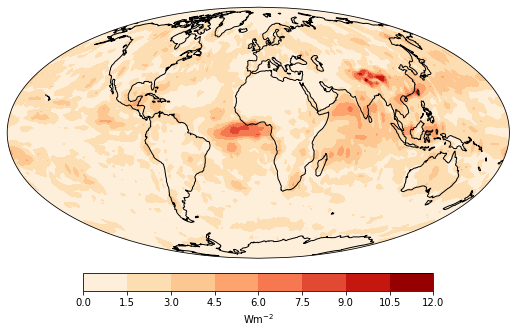

In [61]:
dataset = noresm_spaer
val= ensemble_range_all
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines()
var, ll = add_cyclic_point(ensemble_range_all, coord = dataset.lon) 
 
cs = ax.contourf(ll, dataset.lat, var,transform=ccrs.PlateCarree(),cmap='OrRd')
plt.colorbar(cs, shrink=0.8, fraction=0.046, pad=0.04, extendrect=True, label=r"$\mathrm{Wm}^{-2}$", orientation='horizontal')

In [62]:
ecearth_clr = compute_forcings_clearsky(data_aerosols=ecearth_spaer, data_control=ecearth_control)

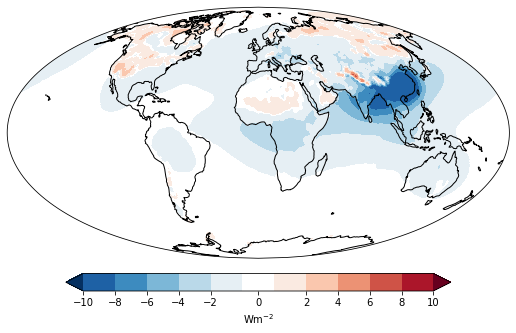

In [63]:
dataset = ecearth_spaer
val= ecearth_clr[0][12:]

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines()

ticks = [-10,-8,-6,-4,-2,0,2,4,6,8,10] 
#colors = ["#053061","#1e61a5","#3d8bbf","#7cb7d7","#bad9e9","white","#fac7ae","#ec9274","#cf5347","#ab162a","#67001f"]
colors = ['#1e61a5','#3d8bbf','#7cb7d7','#bad9e9','#e6eff4','white','#faeae1','#fac7ae','#ec9274','#cf5347','#ab162a']
levels = [-10,-8,-6,-4,-2,-.2,.2,2,4,6,8,10]


cs = ax.contourf(dataset.lon, dataset.lat, np.mean(val, axis=0),transform=ccrs.PlateCarree(), 
                 colors=colors, levels=levels, extend='both')
plt.colorbar(cs, shrink=0.8, fraction=0.046, pad=0.04, extendrect=False,  
             label=r"$\mathrm{Wm}^{-2}$", orientation='horizontal', ticks=ticks)
cs.cmap.set_under("#053061")
cs.cmap.set_over("#67001f")

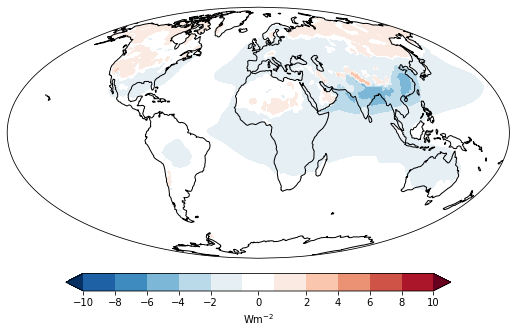

In [64]:
dataset = ecearth_spaer
val= params_ecearth[2][12:]
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines()

ticks = [-10,-8,-6,-4,-2,0,2,4,6,8,10] 
#colors = ["#053061","#1e61a5","#3d8bbf","#7cb7d7","#bad9e9","white","#fac7ae","#ec9274","#cf5347","#ab162a","#67001f"]
colors = ['#1e61a5','#3d8bbf','#7cb7d7','#bad9e9','#e6eff4','white','#faeae1','#fac7ae','#ec9274','#cf5347','#ab162a']
levels = [-10,-8,-6,-4,-2,-.2,.2,2,4,6,8,10]

cs = ax.contourf(dataset.lon, dataset.lat, np.mean(val, axis=0),transform=ccrs.PlateCarree(), 
                 colors=colors,levels=levels, extend='both')
plt.colorbar(cs, shrink=0.8, fraction=0.046, pad=0.04, extendrect=False, 
             label=r"$\mathrm{Wm}^{-2}$", orientation='horizontal', ticks=ticks)
cs.cmap.set_under("#053061")
cs.cmap.set_over("#67001f")

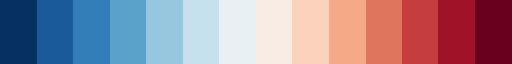

In [65]:
cmap = plt.cm.get_cmap('RdBu_r', 14)
cmap

In [66]:
cmap = plt.cm.get_cmap('YlOrBr', 5)    # PiYG

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    print(mcolors.rgb2hex(rgb))


#ffffe5
#fee391
#fe9929
#cc4c02
#662506


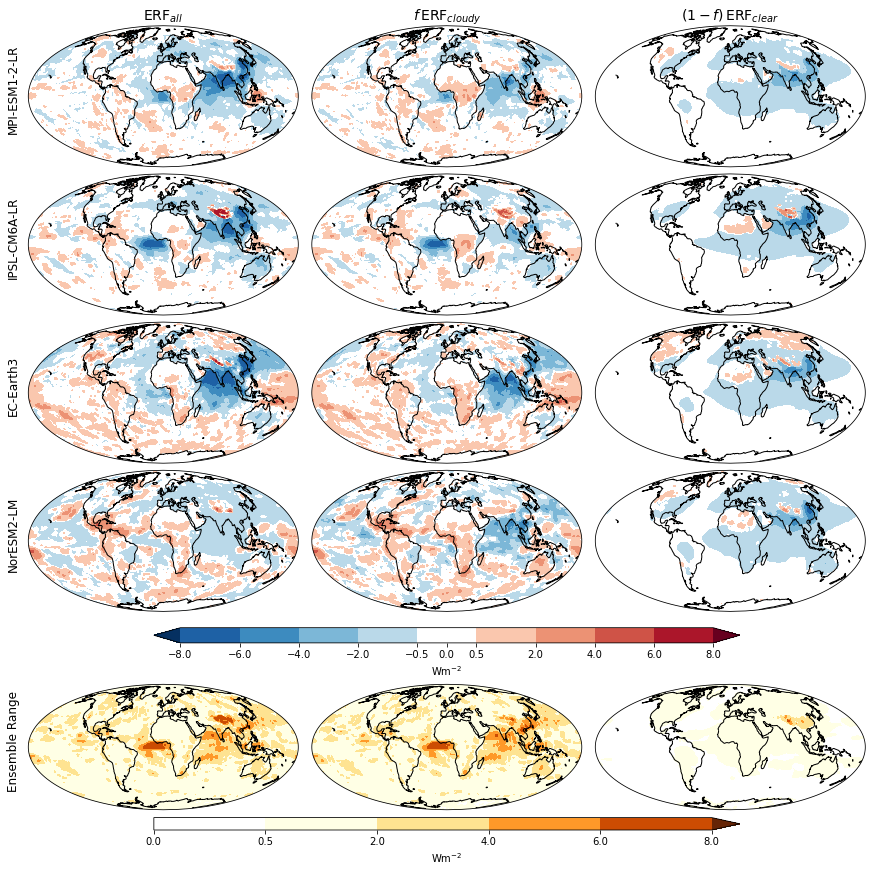

In [68]:
fig, axes = plt.subplots(5, 3,  sharex=True, sharey=True, figsize=(15,15), 
                         subplot_kw=dict(projection=ccrs.Mollweide()),constrained_layout=True)

# use mollweide projection or any other in subplot_kws to make all plots have same projection
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05) #adjust the spacing between subplots

titles = [r'$\mathrm{ERF}_{all}$', r'$f\,\mathrm{ERF}_{cloudy}$',r'$(1-f)\, \mathrm{ERF}_{clear}$'] + [None]*12
labels = ['MPI-ESM1-2-LR',None, None,'IPSL-CM6A-LR',None,None,'EC-Earth3', None,None,'NorESM2-LM',None,None,'Ensemble Range',None,None]

# this is where you can directly include your models/data to plot after you load them. 
# shape of data = (1,lat, lon) or (lat,lon). In the example below, the mean along the time dimension is being taken
# contourf needs variable and lat and lon
# each map to plot in subplot: starts from first row and moves along column, then second row and along column
var = [np.mean(params_mpi[0][24:],axis=0),np.mean(params_mpi[1][24:],axis=0),np.mean(params_mpi[2][24:],axis=0),
       np.mean(params_ipsl[0][12:],axis=0),np.mean(params_ipsl[1][12:],axis=0),np.mean(params_ipsl[2][12:],axis=0),
       np.mean(params_ecearth[0][12:],axis=0),np.mean(params_ecearth[1][12:],axis=0),np.mean(params_ecearth[2][12:],axis=0),
       np.mean(params_noresm[0][12:],axis=0),np.mean(params_noresm[1][12:],axis=0),np.mean(params_noresm[2][12:],axis=0),
       ensemble_range_all, ensemble_range_cld,ensemble_range_cs] 

#dataset to pull lat and lon info since the first 9 subplots do not have the same shape. 
# you can skip this if all your subplots have the same shape and directly insert it in the for loop below
dataset = [mpiesm_spaer]*3 + [ipsl_spaer]*3 + [ecearth_spaer]*3 + [noresm_spaer]*6

# normalize the maps to make sure that it is in the same colour range 
# TwoSlopenorm is when you have negative, zero and postiive values
# Normalize is regular normalization
# the list below is just using the order of the normalization to use for each map
# so the fisrt twelve maps have one type and the last three another type
normalize = [mcolors.TwoSlopeNorm(vmin=-8, vmax=8, vcenter=0)] * 12 + [Normalize(vmin=0,vmax=8)]*3

# ticks you want to plot on the colourbar: size 2n + 1
ticks = [-8,-6,-4,-2,-0.5,0, 0.5,2,4,6,8] 


#use the code in the above cell to retreive hex codes for the colurbar. Must be proportional to the ticks 2n-1
colors_div = ["#1e61a5","#3d8bbf","#7cb7d7","#bad9e9","white","#fac7ae","#ec9274","#cf5347","#ab162a"]
colors_seq = ['white','#ffffe5','#fee391','#fe9929','#cc4c02']
colors = [colors_div]*12 + [colors_seq]*3

# define the levels for the contours. This is the same as the ticks
levels_div1 = [-8,-6,-4,-2,-.5,.5,2,4,6,8]
levels_div2 = [-8,-6,-4,-2,-.2,.2,2,4,6,8]
levels_seq = [0,0.5,2,4,6,8]
levels = [levels_div1]*2 +[levels_div2] +[levels_div1]*2 +[levels_div2] +[levels_div1]*2+[levels_div2] +[levels_div1]*2+[levels_div2]+ [np.arange(0.1,8,2)]*3

for i, ax in enumerate(fig.axes):
    ax.set_global() # for global maps
    ax.coastlines(resolution='110m') # define the coastline
    ax.set_title(titles[i], fontsize=14)
    ax.set_aspect('auto') # to set the aspect ration automatically for each plot
    ax.text(-0.03, 0.55, labels[i], va='bottom', ha='center',rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12) # this is the names of the models on the left hand side
    
    val, ll = add_cyclic_point(var[i], coord = dataset[i].lon) # to remove white line at 0 longitude
    cs = ax.contourf(ll, dataset[i].lat, val,
                     norm=normalize[i], 
                     transform=ccrs.PlateCarree(), #needs to transform the map and then plot on projection
                     colors=colors[i],
                     levels = levels[i],
                     extend='both') # controls the contour in case of extending colourbars, here both min and max

# convert the colours, levels and normalization for the different colour schemes in the complete figure
cmap = mcolors.ListedColormap(colors_div)
norm = mcolors.BoundaryNorm(levels_div1, cmap.N) 
# this gives more control on making sure the colourbar has the exact colours and levels used in the maps
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        
# plot the colourbar
# ax=axes[row, coloumns]
# change fraction of space colourbar must occupy in the whole figure
# aspect ratio of the colourbar
# shirnk to change the size of colourbar
# padding to change space between subplots and colourbar
# extendrect set to False so we have a triangle end 
# extend both so we have triangle ends on both sides
cbar = fig.colorbar(sm, ax=axes[:4,0:3], orientation='horizontal',label=r"$\mathrm{Wm}^{-2}$", 
                    fraction=0.075, aspect=35,shrink=0.7, pad=0.025, extendrect=False, extend='both', ticks=ticks)
# colours for the max and min value
cbar.cmap.set_under("#053061")
cbar.cmap.set_over("#67001f")

# repeat the same for the other colourbar but with different colours, norm, levels etc
cmap_seq = mcolors.ListedColormap(colors_seq)
norm_seq = mcolors.BoundaryNorm(levels_seq, cmap_seq.N)    
sm_seq = plt.cm.ScalarMappable(norm=norm_seq, cmap=cmap_seq)

cbar_orange = fig.colorbar(sm_seq, ax=axes[4, 0:3], orientation='horizontal',
             label=r"$\mathrm{Wm}^{-2}$",aspect=45,shrink=0.7, pad=0.05,extendrect=False, extend='max',
            ticks=[0,0.5,2,4,6,8])
cbar_orange.cmap.set_over("#662506")

#plt.savefig('rfmip_erf_updated.pdf', bbox_inches='tight', transparent=True)

plt.show()

In [69]:
lw_mpi_all = regrid_params_mpi[3][24:].assign_coords({'time':('time',
                                               pd.date_range('1850-01-1', 
                                                             periods=len(regrid_params_mpi[3][24:].time.values), 
                                                             freq='M').values,
                                               regrid_params_mpi[3].time.attrs)})
lw_ipsl_all = regrid_params_ipsl[3][12:].assign_coords({'time':('time',
                                                 pd.date_range('1850-01-1', 
                                                               periods=len(regrid_params_ipsl[3][12:].time.values), 
                                                               freq='M').values,
                                                 regrid_params_ipsl[3].time.attrs)})
lw_ecearth_all = regrid_params_ecearth[3][12:].assign_coords({'time':('time',
                                                 pd.date_range('1850-01-1', 
                                                               periods=len(regrid_params_ecearth[3][12:].time.values), 
                                                               freq='M').values,
                                                 regrid_params_ecearth[3].time.attrs)})
lw_noresm_all = params_noresm[3][12:].assign_coords({'time':('time',
                                                          pd.date_range('1850-01-1', 
                                                                        periods=len(params_noresm[3][12:].time.values), 
                                                                        freq='M').values,
                                                          params_noresm[3].time.attrs)})

lw_mpi_cld = regrid_params_mpi[4][24:].assign_coords({'time':('time',
                                               pd.date_range('1850-01-1', 
                                                             periods=len(regrid_params_mpi[4][24:].time.values), 
                                                             freq='M').values,
                                               regrid_params_mpi[4].time.attrs)})
lw_ipsl_cld = regrid_params_ipsl[4][12:].assign_coords({'time':('time',
                                                 pd.date_range('1850-01-1', 
                                                               periods=len(regrid_params_ipsl[4][12:].time.values), 
                                                               freq='M').values,
                                                 regrid_params_ipsl[4].time.attrs)})
lw_ecearth_cld = regrid_params_ecearth[4][12:].assign_coords({'time':('time',
                                                 pd.date_range('1850-01-1', 
                                                               periods=len(regrid_params_ecearth[4][12:].time.values), 
                                                               freq='M').values,
                                                 regrid_params_ecearth[4].time.attrs)})
lw_noresm_cld = params_noresm[4][12:].assign_coords({'time':('time',
                                                          pd.date_range('1850-01-1', 
                                                                        periods=len(params_noresm[4][12:].time.values), 
                                                                        freq='M').values,
                                                          params_noresm[4].time.attrs)})

lw_mpi_clr = regrid_params_mpi[5][24:].assign_coords({'time':('time',
                                               pd.date_range('1850-01-1', 
                                                             periods=len(regrid_params_mpi[5][24:].time.values), 
                                                             freq='M').values,
                                               regrid_params_mpi[5].time.attrs)})
lw_ipsl_clr = regrid_params_ipsl[5][12:].assign_coords({'time':('time',
                                                 pd.date_range('1850-01-1', 
                                                               periods=len(regrid_params_ipsl[5][12:].time.values), 
                                                               freq='M').values,
                                                 regrid_params_ipsl[5].time.attrs)})
lw_ecearth_clr = regrid_params_ecearth[5][12:].assign_coords({'time':('time',
                                                 pd.date_range('1850-01-1', 
                                                               periods=len(regrid_params_ecearth[5][12:].time.values), 
                                                               freq='M').values,
                                                 regrid_params_ecearth[5].time.attrs)})
lw_noresm_clr = params_noresm[5][12:].assign_coords({'time':('time',
                                                          pd.date_range('1850-01-1', 
                                                                        periods=len(params_noresm[5][12:].time.values), 
                                                                        freq='M').values,
                                                          params_noresm[5].time.attrs)})

In [72]:
# inlcuding longwave radiation

# compute model range
ensemble_mean_all_lw = xr.concat([lw_mpi_all,lw_ipsl_all,lw_ecearth_all,lw_noresm_all],dim='model').mean('time')
ensemble_mean_all_lw.shape

(4, 96, 144)

In [70]:
ensemble_mean_cld_lw = xr.concat([lw_mpi_cld,lw_ipsl_cld,lw_ecearth_cld,lw_noresm_cld],dim='model').mean('time')
ensemble_mean_cs_lw = xr.concat([lw_mpi_clr,lw_ipsl_clr,lw_ecearth_clr,lw_noresm_clr],dim='model').mean('time')

In [73]:
ensemble_range_all_lw = ensemble_mean_all_lw.max(dim='model') - ensemble_mean_all_lw.min(dim='model')
ensemble_range_cs_lw = ensemble_mean_cs_lw.max(dim='model') - ensemble_mean_cs_lw.min(dim='model')
ensemble_range_cld_lw = ensemble_mean_cld_lw.max(dim='model') - ensemble_mean_cld_lw.min(dim='model')
ensemble_range_all_lw.shape

(96, 144)

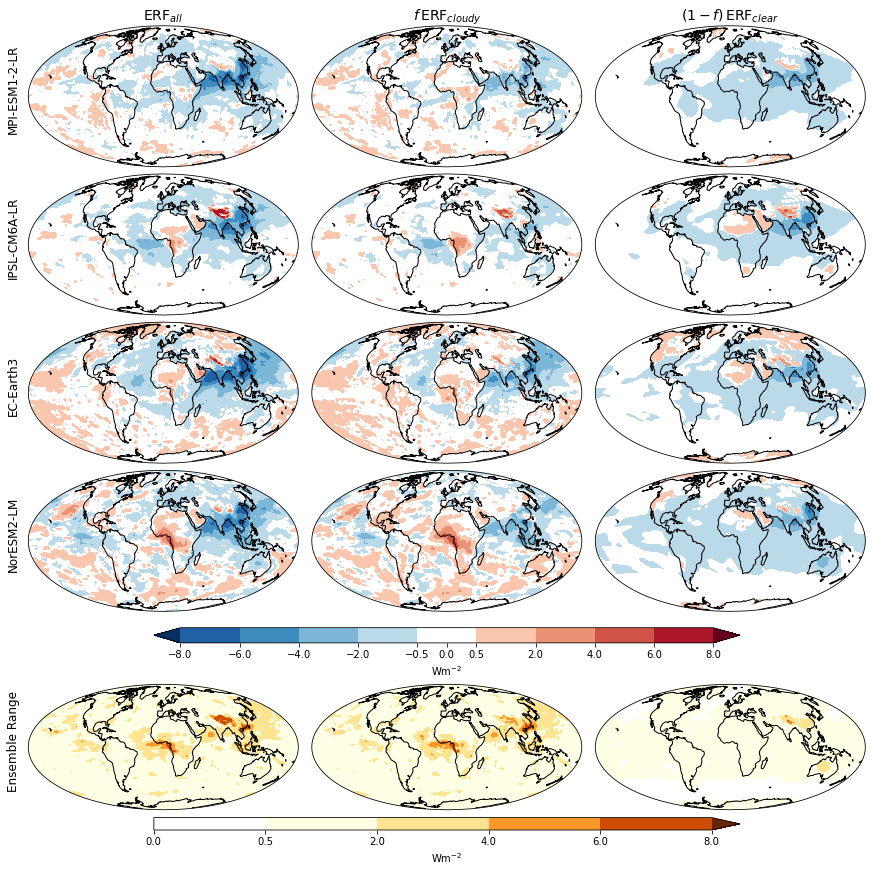

In [80]:
fig, axes = plt.subplots(5, 3,  sharex=True, sharey=True, figsize=(15,15), 
                         subplot_kw=dict(projection=ccrs.Mollweide()),constrained_layout=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

titles = [r'$\mathrm{ERF}_{all}$', r'$f\,\mathrm{ERF}_{cloudy}$',r'$(1-f)\, \mathrm{ERF}_{clear}$'] + [None]*12
labels = ['MPI-ESM1-2-LR',None, None,'IPSL-CM6A-LR',None,None,'EC-Earth3', None,None,'NorESM2-LM',None,None,'Ensemble Range',None,None]

var = [np.mean(params_mpi[3][24:],axis=0),np.mean(params_mpi[4][24:],axis=0),np.mean(params_mpi[5][24:],axis=0),
       np.mean(params_ipsl[3][12:],axis=0),np.mean(params_ipsl[4][12:],axis=0),np.mean(params_ipsl[5][12:],axis=0),
       np.mean(params_ecearth[3][12:],axis=0),np.mean(params_ecearth[4][12:],axis=0),np.mean(params_ecearth[5][12:],axis=0),
       np.mean(params_noresm[3][12:],axis=0),np.mean(params_noresm[4][12:],axis=0),np.mean(params_noresm[5][12:],axis=0),
       ensemble_range_all_lw, ensemble_range_cld_lw,ensemble_range_cs_lw]
dataset = [mpiesm_spaer]*3 + [ipsl_spaer]*3 + [ecearth_spaer]*3 + [noresm_spaer]*6

normalize = [mcolors.TwoSlopeNorm(vmin=-8, vmax=8, vcenter=0)] * 12 + [Normalize(vmin=0,vmax=8)]*3

ticks = [-8,-6,-4,-2,-0.5,0, 0.5,2,4,6,8] 

colors_div = ["#1e61a5","#3d8bbf","#7cb7d7","#bad9e9","white","#fac7ae","#ec9274","#cf5347","#ab162a"]
colors_seq = ['white','#ffffe5','#fee391','#fe9929','#cc4c02']
colors = [colors_div]*12 + [colors_seq]*3

levels_div1 = [-8,-6,-4,-2,-.5,.5,2,4,6,8]
levels_div2 = [-8,-6,-4,-2,-.2,.2,2,4,6,8]
levels_seq = [0,0.5,2,4,6,8]
levels = [levels_div1]*2 +[levels_div2] +[levels_div1]*2 +[levels_div2] +[levels_div1]*2+[levels_div2] +[levels_div1]*2+[levels_div2]+ [np.arange(0.1,8,2)]*3

for i, ax in enumerate(fig.axes):
    ax.set_global()
    ax.coastlines(resolution='110m')
    ax.set_title(titles[i], fontsize=14)
    ax.set_aspect('auto')
    ax.text(-0.03, 0.55, labels[i], va='bottom', ha='center',rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12)
    
    val, ll = add_cyclic_point(var[i], coord = dataset[i].lon)
    cs = ax.contourf(ll, dataset[i].lat, val,
                     norm=normalize[i], 
                     transform=ccrs.PlateCarree(),
                     colors=colors[i],
                     levels = levels[i],
                     extend='both')

cmap = mcolors.ListedColormap(colors_div)
norm = mcolors.BoundaryNorm(levels_div1, cmap.N)    
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        
cbar = fig.colorbar(sm, ax=axes[:4,0:3], orientation='horizontal',label=r"$\mathrm{Wm}^{-2}$", 
                    fraction=0.075, aspect=35,shrink=0.7, pad=0.025, extendrect=False, extend='both', ticks=ticks)
cbar.cmap.set_under("#053061")
cbar.cmap.set_over("#67001f")

cmap_seq = mcolors.ListedColormap(colors_seq)
norm_seq = mcolors.BoundaryNorm(levels_seq, cmap_seq.N)    
sm_seq = plt.cm.ScalarMappable(norm=norm_seq, cmap=cmap_seq)

cbar_orange = fig.colorbar(sm_seq, ax=axes[4, 0:3], orientation='horizontal',
             label=r"$\mathrm{Wm}^{-2}$",aspect=45,shrink=0.7, pad=0.05,extendrect=False, extend='max',
            ticks=[0,0.5,2,4,6,8])
cbar_orange.cmap.set_over("#662506")

plt.savefig('rfmip_erf_lw_updated.pdf', bbox_inches='tight', transparent=True)

plt.show()

In [35]:
# differences 

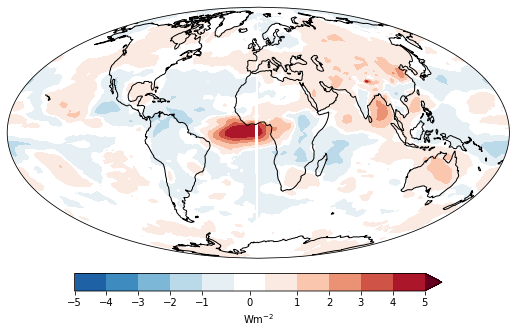

In [75]:
dataset = ipsl_spaer
val= params_ipsl[3][12:] - params_ipsl[0][12:]
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines()

ticks = [-5,-4,-3,-2,-1,0,1,2,3,4,5] 
#colors = ["#053061","#1e61a5","#3d8bbf","#7cb7d7","#bad9e9","white","#fac7ae","#ec9274","#cf5347","#ab162a","#67001f"]
colors = ['#1e61a5','#3d8bbf','#7cb7d7','#bad9e9','#e6eff4','white','#faeae1','#fac7ae','#ec9274','#cf5347','#ab162a']
levels = [-5,-4,-3,-2,-1,-.2,.2,1,2,3,4,5]

cs = ax.contourf(dataset.lon, dataset.lat, np.mean(val, axis=0),transform=ccrs.PlateCarree(), 
                 colors=colors,levels=levels, extend='max')
plt.colorbar(cs, shrink=0.8, fraction=0.046, pad=0.04, extendrect=False, 
             label=r"$\mathrm{Wm}^{-2}$", orientation='horizontal', ticks=ticks)
cs.cmap.set_under("#053061")
cs.cmap.set_over("#67001f")

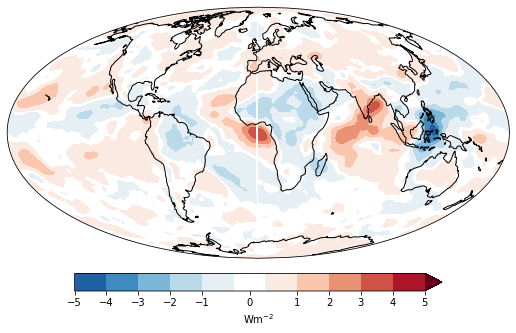

In [76]:
dataset = mpiesm_spaer
val= params_mpi[3][24:] - params_mpi[0][24:]
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines()

ticks = [-5,-4,-3,-2,-1,0,1,2,3,4,5] 
#colors = ["#053061","#1e61a5","#3d8bbf","#7cb7d7","#bad9e9","white","#fac7ae","#ec9274","#cf5347","#ab162a","#67001f"]
colors = ['#1e61a5','#3d8bbf','#7cb7d7','#bad9e9','#e6eff4','white','#faeae1','#fac7ae','#ec9274','#cf5347','#ab162a']
levels = [-5,-4,-3,-2,-1,-.2,.2,1,2,3,4,5]

cs = ax.contourf(dataset.lon, dataset.lat, np.mean(val, axis=0),transform=ccrs.PlateCarree(), 
                 colors=colors,levels=levels, extend='max')
plt.colorbar(cs, shrink=0.8, fraction=0.046, pad=0.04, extendrect=False, 
             label=r"$\mathrm{Wm}^{-2}$", orientation='horizontal', ticks=ticks)
cs.cmap.set_under("#053061")
cs.cmap.set_over("#67001f")

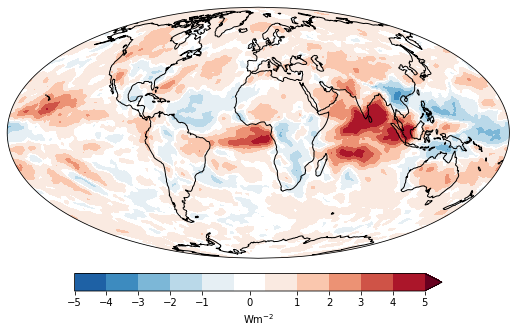

In [77]:
dataset = ecearth_spaer
val= params_ecearth[3][12:] - params_ecearth[0][12:]
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines()

ticks = [-5,-4,-3,-2,-1,0,1,2,3,4,5] 
#colors = ["#053061","#1e61a5","#3d8bbf","#7cb7d7","#bad9e9","white","#fac7ae","#ec9274","#cf5347","#ab162a","#67001f"]
colors = ['#1e61a5','#3d8bbf','#7cb7d7','#bad9e9','#e6eff4','white','#faeae1','#fac7ae','#ec9274','#cf5347','#ab162a']
levels = [-5,-4,-3,-2,-1,-.2,.2,1,2,3,4,5]

cs = ax.contourf(dataset.lon, dataset.lat, np.mean(val, axis=0),transform=ccrs.PlateCarree(), 
                 colors=colors,levels=levels, extend='max')
plt.colorbar(cs, shrink=0.8, fraction=0.046, pad=0.04, extendrect=False, 
             label=r"$\mathrm{Wm}^{-2}$", orientation='horizontal', ticks=ticks)
cs.cmap.set_under("#053061")
cs.cmap.set_over("#67001f")

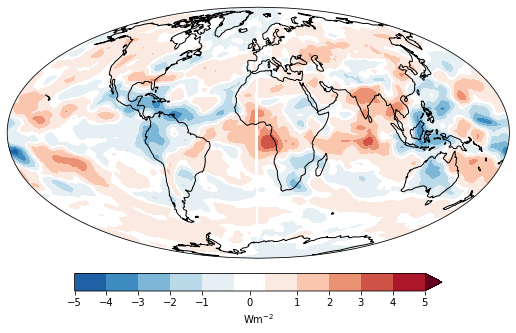

In [78]:
dataset = noresm_spaer
val= params_noresm[3][12:] - params_noresm[0][12:]
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines()

ticks = [-5,-4,-3,-2,-1,0,1,2,3,4,5] 
#colors = ["#053061","#1e61a5","#3d8bbf","#7cb7d7","#bad9e9","white","#fac7ae","#ec9274","#cf5347","#ab162a","#67001f"]
colors = ['#1e61a5','#3d8bbf','#7cb7d7','#bad9e9','#e6eff4','white','#faeae1','#fac7ae','#ec9274','#cf5347','#ab162a']
levels = [-5,-4,-3,-2,-1,-.2,.2,1,2,3,4,5]

cs = ax.contourf(dataset.lon, dataset.lat, np.mean(val, axis=0),transform=ccrs.PlateCarree(), 
                 colors=colors,levels=levels, extend='max')
plt.colorbar(cs, shrink=0.8, fraction=0.046, pad=0.04, extendrect=False, 
             label=r"$\mathrm{Wm}^{-2}$", orientation='horizontal', ticks=ticks)
cs.cmap.set_under("#053061")
cs.cmap.set_over("#67001f")

In [22]:
# global mean values

def global_mean(forcing_data):
    ''' Calculate the global mean value of given data with (lat,lon) coordinates
        Parameters:
        -----------

        data: 3D or 2D xarray.DataArray/ numpy.ndarray
              can be forcing, SST, temperature, preciptitation, etc. over a sphere. 
              For 2D ndarray, axis has to be changed to 0

        Returns:
        --------
        global_mean: float64
                     spatial and/or temporal mean.  Use only 2 decimal points
    '''

    weight = np.cos(np.deg2rad(forcing_data.lat))
    annual_data = forcing_data.groupby('time.year').mean(dim='time')
    annual_mean = annual_data.weighted(weight).mean(dim=("lon", "lat"))
    global_mean = np.round(float(annual_mean.mean()),2)
    global_std = np.round(float(annual_mean.std()),2)
    
    return global_mean

In [23]:
mpi_all = global_mean(params_mpi[0][24:])
ipsl_all = global_mean(params_ipsl[0][12:])
ecearth_all = global_mean(params_ecearth[0][12:])
noresm_all = global_mean(params_noresm[0][12:])

mpi_cld = global_mean(params_mpi[1][24:])
ipsl_cld = global_mean(params_ipsl[1][12:])
ecearth_cld = global_mean(params_ecearth[1][12:])
noresm_cld = global_mean(params_noresm[1][12:])

mpi_clr = global_mean(params_mpi[2][24:])
ipsl_clr = global_mean(params_ipsl[2][12:])
ecearth_clr = global_mean(params_ecearth[2][12:])
noresm_clr = global_mean(params_noresm[2][12:])

In [24]:
lw_mpi_all = global_mean(params_mpi[3][24:])
lw_ipsl_all = global_mean(params_ipsl[3][12:])
lw_ecearth_all = global_mean(params_ecearth[3][12:])
lw_noresm_all = global_mean(params_noresm[3][12:])

lw_mpi_cld = global_mean(params_mpi[4][24:])
lw_ipsl_cld = global_mean(params_ipsl[4][12:])
lw_ecearth_cld = global_mean(params_ecearth[4][12:])
lw_noresm_cld = global_mean(params_noresm[4][12:])

lw_mpi_clr = global_mean(params_mpi[5][24:])
lw_ipsl_clr = global_mean(params_ipsl[5][12:])
lw_ecearth_clr = global_mean(params_ecearth[5][12:])
lw_noresm_clr = global_mean(params_noresm[5][12:])

In [25]:
# erf clear

sw_mpi_clr = global_mean(params_mpi[6][24:])
sw_ipsl_clr = global_mean(params_ipsl[6][12:])
sw_ecearth_clr = global_mean(params_ecearth[6][12:])
sw_noresm_clr = global_mean(params_noresm[6][12:])

lwcorr_mpi_clr = global_mean(params_mpi[7][24:])
lwcorr_ipsl_clr = global_mean(params_ipsl[7][12:])
lwcorr_ecearth_clr = global_mean(params_ecearth[7][12:])
lwcorr_noresm_clr = global_mean(params_noresm[7][12:])

In [26]:
data = [[mpi_all, lw_mpi_all, mpi_clr, lw_mpi_clr, sw_mpi_clr, lwcorr_mpi_clr], 
        [ipsl_all, lw_ipsl_all, ipsl_clr, lw_ipsl_clr, sw_ipsl_clr, lwcorr_ipsl_clr],
        [noresm_all, lw_noresm_all, noresm_clr, lw_noresm_clr, sw_mpi_clr, lwcorr_noresm_clr],
        [ecearth_all, lw_ecearth_all, ecearth_clr, lw_ecearth_clr, sw_ecearth_clr, lwcorr_ecearth_clr]
       ]

header = pd.MultiIndex.from_product([['ERF_all','fERF_clr', 'ERF_clr'],
                                     ['SW','SW + LW']]
                                   )
df = pd.DataFrame(data, index=['MPI-ESM1.2-LR','IPSL-CM6A-LR','NorESM2-LM','EC-EARTH3'], columns=header)
df

ERF_all         fERF_clr         ERF_clr        
                   SW SW + LW       SW SW + LW      SW SW + LW
MPI-ESM1.2-LR   -0.60   -0.59    -0.27   -0.31   -0.67   -0.65
IPSL-CM6A-LR    -0.53   -0.50    -0.27   -0.27   -0.59   -0.53
NorESM2-LM      -0.59   -0.57    -0.30   -0.41   -0.67   -0.72
EC-EARTH3       -0.87   -0.84    -0.27   -0.36   -0.73   -0.67

In [27]:
df.mean()

ERF_all   SW        -0.6475
          SW + LW   -0.6250
fERF_clr  SW        -0.2775
          SW + LW   -0.3375
ERF_clr   SW        -0.6650
          SW + LW   -0.6425
dtype: float64

In [93]:
# resolution
#ipsl lon 2.5 lat -90.0 -88.73 -87.46, tripolar 1 deg
#ecearth lon 0.0 0.3516 0.7031 ... 359.3 359.6 lat -89.46 -88.77 ... 88.77 89.46 tripolar 1 deg
#mpiesm lon 0.0 1.875 3.75 ... 356.2 358.1 lat -88.57 -86.72 ... 86.72 88.57 bipolar 1.5
#noresm lon 0.0 2.5 5.0 ... 352.5 355.0 357.5 lat -90.0 -88.11 -86.21 ... 88.11 90.0 atmos 2 deg ocean 1 deg

In [28]:
# testing cloudy ERF
#forcing_allsky[0], sw_fcloudy, sw_fclear, forcing_allsky[1],lw_fcloudy, lw_fclear, from params_model
# difference between all - clear and fcloudy

params_mpi_allsky = compute_forcings_allsky(data_aerosols=mpiesm_spaer, data_control=mpiesm_control)
params_ipsl_allsky = compute_forcings_allsky(data_aerosols=ipsl_spaer, data_control=ipsl_control)
params_noresm_allsky = compute_forcings_allsky(data_aerosols=noresm_spaer, data_control=noresm_control)
params_ecearth_allsky = compute_forcings_allsky(data_aerosols=ecearth_spaer, data_control=ecearth_control)

params_mpi_clearsky = compute_forcings_clearsky(data_aerosols=mpiesm_spaer, data_control=mpiesm_control)
params_ipsl_clearsky = compute_forcings_clearsky(data_aerosols=ipsl_spaer, data_control=ipsl_control)
params_noresm_clearsky = compute_forcings_clearsky(data_aerosols=noresm_spaer, data_control=noresm_control)
params_ecearth_clearsky = compute_forcings_clearsky(data_aerosols=ecearth_spaer, data_control=ecearth_control)

In [29]:
mpi_erfcloud_sw = params_mpi_allsky[0] - params_mpi_clearsky[0]
mpi_erfcloud_lw = params_mpi_allsky[1] - params_mpi_clearsky[1]

ipsl_erfcloud_sw = params_ipsl_allsky[0] - params_ipsl_clearsky[0]
ipsl_erfcloud_lw = params_ipsl_allsky[1] - params_ipsl_clearsky[1]

noresm_erfcloud_sw = params_noresm_allsky[0] - params_noresm_clearsky[0]
noresm_erfcloud_lw = params_noresm_allsky[1] - params_noresm_clearsky[1]

ecearth_erfcloud_sw = params_ecearth_allsky[0] - params_ecearth_clearsky[0]
ecearth_erfcloud_lw = params_ecearth_allsky[1] - params_ecearth_clearsky[1]

In [30]:
diff_mpi = params_mpi[1] - mpi_erfcloud_sw
diff_mpi_lw = params_mpi[4] - mpi_erfcloud_lw

diff_ipsl = params_ipsl[1] - ipsl_erfcloud_sw
diff_ipsl_lw = params_ipsl[4] - ipsl_erfcloud_lw

diff_noresm = params_noresm[1] - noresm_erfcloud_sw
diff_noresm_lw = params_noresm[4] - noresm_erfcloud_lw

diff_ecearth = params_ecearth[1] - ecearth_erfcloud_sw
diff_ecearth_lw = params_ecearth[4] - ecearth_erfcloud_lw

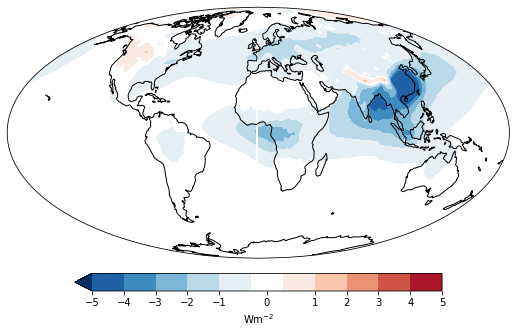

In [26]:
dataset = mpiesm_spaer
val= diff_mpi
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1,projection=ccrs.Mollweide())
ax.set_global()
ax.coastlines()

ticks = [-5,-4,-3,-2,-1,0,1,2,3,4,5] 
#colors = ["#053061","#1e61a5","#3d8bbf","#7cb7d7","#bad9e9","white","#fac7ae","#ec9274","#cf5347","#ab162a","#67001f"]
colors = ['#1e61a5','#3d8bbf','#7cb7d7','#bad9e9','#e6eff4','white','#faeae1','#fac7ae','#ec9274','#cf5347','#ab162a']
levels = [-5,-4,-3,-2,-1,-.2,.2,1,2,3,4,5]

cs = ax.contourf(dataset.lon, dataset.lat, np.mean(val, axis=0),transform=ccrs.PlateCarree(), 
                 colors=colors,levels=levels, extend='min')
plt.colorbar(cs, shrink=0.8, fraction=0.046, pad=0.04, extendrect=False, 
             label=r"$\mathrm{Wm}^{-2}$", orientation='horizontal', ticks=ticks)
cs.cmap.set_under("#053061")
cs.cmap.set_over("#67001f")

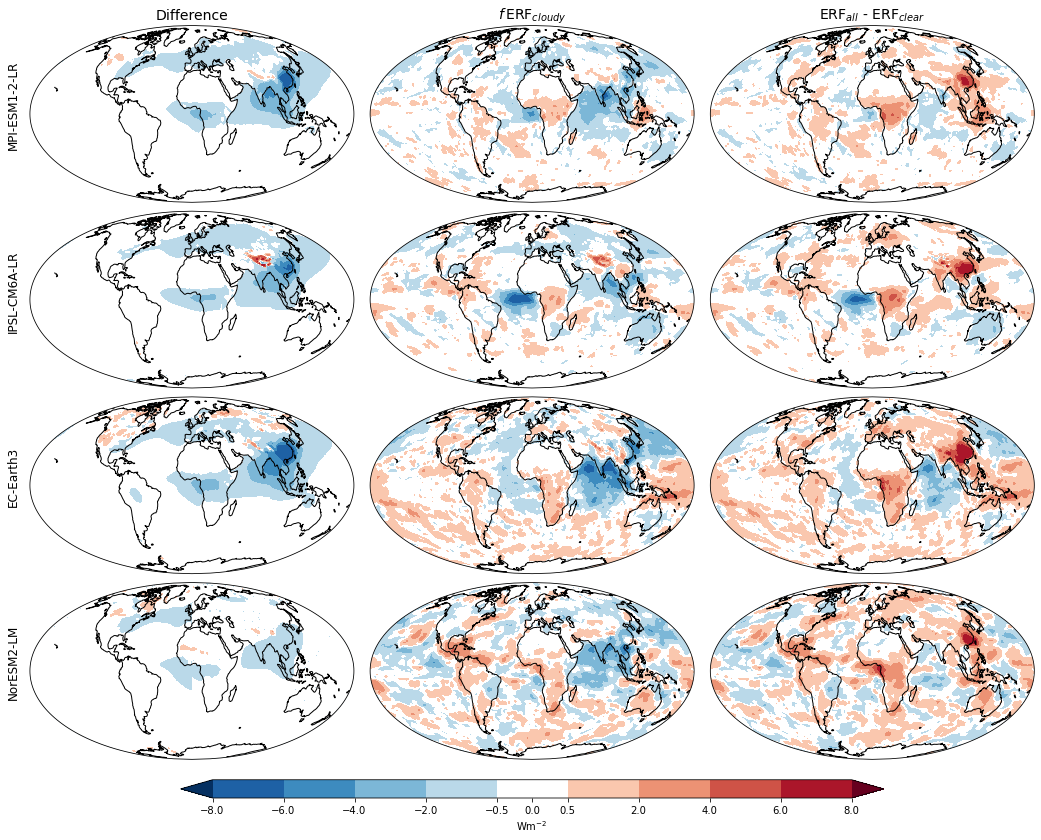

In [34]:
fig, axes = plt.subplots(4, 3,  sharex=True, sharey=True, figsize=(18,15), 
                         subplot_kw=dict(projection=ccrs.Mollweide()),constrained_layout=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

titles = ['Difference', r'$f\,\mathrm{ERF}_{cloudy}$',r'$\mathrm{ERF}_{all}$ - $\mathrm{ERF}_{clear}$'] + [None]*9
labels = ['MPI-ESM1-2-LR',None, None,'IPSL-CM6A-LR',None,None,'EC-Earth3', None,None,'NorESM2-LM',None,None]
var = [diff_mpi, params_mpi[1], mpi_erfcloud_sw,
       diff_ipsl, params_ipsl[1], ipsl_erfcloud_sw,
       diff_ecearth, params_ecearth[1], ecearth_erfcloud_sw,
       diff_noresm, params_noresm[1], noresm_erfcloud_sw
      ]
dataset = [mpiesm_spaer]*3 + [ipsl_spaer]*3 + [ecearth_spaer]*3 + [noresm_spaer]*3

normalize = [mcolors.TwoSlopeNorm(vmin=-8, vmax=8, vcenter=0)] * 12 

ticks = [-8,-6,-4,-2,-0.5,0, 0.5,2,4,6,8] 

colors_div = ["#1e61a5","#3d8bbf","#7cb7d7","#bad9e9","white","#fac7ae","#ec9274","#cf5347","#ab162a"]
colors = [colors_div]*12 
levels_div1 = [-8,-6,-4,-2,-.5,.5,2,4,6,8]
levels_div2 = [-8,-6,-4,-2,-.5,.5,2,4,6,8]

levels = [levels_div1]*2 +[levels_div2] +[levels_div1]*2 +[levels_div2] +[levels_div1]*2+[levels_div2] +[levels_div1]*2+[levels_div2]

for i, ax in enumerate(fig.axes):
    ax.set_global()
    ax.coastlines(resolution='110m')
    ax.set_title(titles[i], fontsize=14)
    ax.set_aspect('auto')
    ax.text(-0.03, 0.55, labels[i], va='bottom', ha='center',rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12)
    
    val, ll = add_cyclic_point(var[i], coord = dataset[i].lon)
    cs = ax.contourf(ll, dataset[i].lat, np.mean(val, axis=0),
                     norm=normalize[i], 
                     transform=ccrs.PlateCarree(),
                     colors=colors[i],
                     levels = levels[i],
                     extend='both')

cmap = mcolors.ListedColormap(colors_div)
norm = mcolors.BoundaryNorm(levels_div1, cmap.N)    
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        
cbar = fig.colorbar(sm, ax=axes[:4,0:3], orientation='horizontal',label=r"$\mathrm{Wm}^{-2}$", 
                    fraction=0.075, aspect=35,shrink=0.7, pad=0.025, extendrect=False, extend='both', ticks=ticks)
cbar.cmap.set_under("#053061")
cbar.cmap.set_over("#67001f")

#plt.savefig('rfmip_erf_cloud_diff_sw.pdf', bbox_inches='tight', transparent=True)

plt.show()

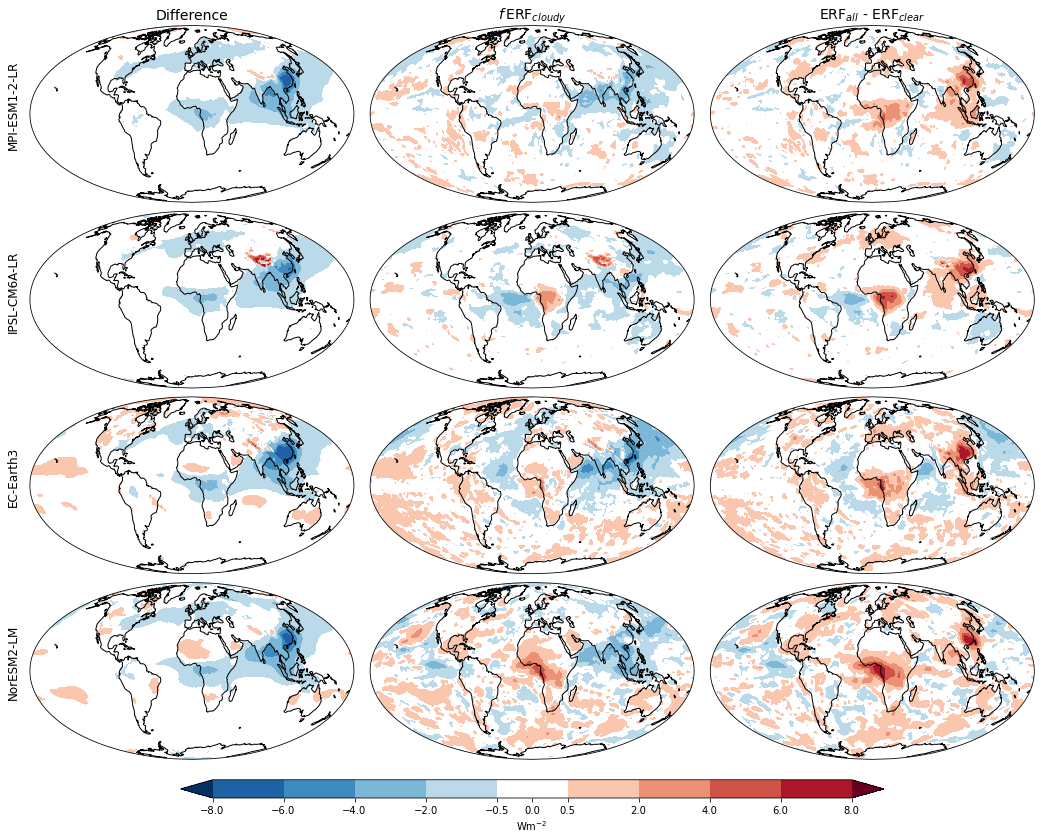

In [35]:
fig, axes = plt.subplots(4, 3,  sharex=True, sharey=True, figsize=(18,15), 
                         subplot_kw=dict(projection=ccrs.Mollweide()),constrained_layout=True)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

titles = ['Difference', r'$f\,\mathrm{ERF}_{cloudy}$',r'$\mathrm{ERF}_{all}$ - $\mathrm{ERF}_{clear}$'] + [None]*9
labels = ['MPI-ESM1-2-LR',None, None,'IPSL-CM6A-LR',None,None,'EC-Earth3', None,None,'NorESM2-LM',None,None]
var = [diff_mpi_lw, params_mpi[4], mpi_erfcloud_lw,
       diff_ipsl_lw, params_ipsl[4], ipsl_erfcloud_lw,
       diff_ecearth_lw, params_ecearth[4], ecearth_erfcloud_lw,
       diff_noresm_lw, params_noresm[4], noresm_erfcloud_lw
      ]
dataset = [mpiesm_spaer]*3 + [ipsl_spaer]*3 + [ecearth_spaer]*3 + [noresm_spaer]*3

normalize = [mcolors.TwoSlopeNorm(vmin=-8, vmax=8, vcenter=0)] * 12 

ticks = [-8,-6,-4,-2,-0.5,0, 0.5,2,4,6,8] 

colors_div = ["#1e61a5","#3d8bbf","#7cb7d7","#bad9e9","white","#fac7ae","#ec9274","#cf5347","#ab162a"]
colors = [colors_div]*12 
levels_div1 = [-8,-6,-4,-2,-.5,.5,2,4,6,8]
levels_div2 = [-8,-6,-4,-2,-.5,.5,2,4,6,8]

levels = [levels_div1]*2 +[levels_div2] +[levels_div1]*2 +[levels_div2] +[levels_div1]*2+[levels_div2] +[levels_div1]*2+[levels_div2]

for i, ax in enumerate(fig.axes):
    ax.set_global()
    ax.coastlines(resolution='110m')
    ax.set_title(titles[i], fontsize=14)
    ax.set_aspect('auto')
    ax.text(-0.03, 0.55, labels[i], va='bottom', ha='center',rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12)
    
    val, ll = add_cyclic_point(var[i], coord = dataset[i].lon)
    cs = ax.contourf(ll, dataset[i].lat, np.mean(val, axis=0),
                     norm=normalize[i], 
                     transform=ccrs.PlateCarree(),
                     colors=colors[i],
                     levels = levels[i],
                     extend='both')

cmap = mcolors.ListedColormap(colors_div)
norm = mcolors.BoundaryNorm(levels_div1, cmap.N)    
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        
cbar = fig.colorbar(sm, ax=axes[:4,0:3], orientation='horizontal',label=r"$\mathrm{Wm}^{-2}$", 
                    fraction=0.075, aspect=35,shrink=0.7, pad=0.025, extendrect=False, extend='both', ticks=ticks)
cbar.cmap.set_under("#053061")
cbar.cmap.set_over("#67001f")

#plt.savefig('rfmip_erf_cloud_diff_lw.pdf', bbox_inches='tight', transparent=True)

plt.show()